In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime as dt
import portfolioopt as port
import blacklitterman as bl


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# Trabalho Final Wealth Management

Leonardo Barros 333799
Pedro Mattos 333791
Veridiana Fonseca

# Carregar e Manipular Series

In [2]:
def plotLines(series, legends, title):

    data = []

    i=0
    for serie in series:
        trace = go.Scatter(
            x = pd.to_datetime(serie.index.values),
            y = serie / 1000,
            name = legends[i]
        )
        data.append(trace)
        i += 1

    layout = dict(title = title,
                  xaxis = dict(title = 'Date'),
                  yaxis = dict(title = 'Return'),
                  )
    fig = dict(data=data, layout=layout)
    iplot(fig)

In [3]:
# assets = [
#     'PETR4',
#     'VALE5',
#     'IBOV',
# ]

# dfs = {}
# for name in assets:
#     dfs[name] = pd.read_csv(name + '.txt', sep=',')
#     dfs[name]['Date'] = dfs[name]['Date'].apply(pd.to_datetime)
#     dfs[name].set_index('Date',inplace=True)
#     dfs[name].sort_index(inplace=True)
#     dfs[name][name] = dfs[name]['Close'].pct_change()

In [4]:
assets = [
    'IMAB',
#     'IMAS',
    'USDBRL',
    'IBOV',
]


dfs = {}
for name in assets:
    dfs[name] = pd.read_csv(name + '.csv', sep=',')
    dfs[name]['Date'] = dfs[name]['Date'].apply(pd.to_datetime)
    dfs[name].set_index('Date',inplace=True)
    dfs[name].sort_index(inplace=True)
    dfs[name]['Close'] = dfs[name][name]
    dfs[name][name] = dfs[name][name].fillna(method='ffill').pct_change()

In [5]:
returns = []
for name in assets:
    returns.append(dfs[name][name])
    
returns = pd.concat(returns,axis=1)   

prices = []
for name in assets:
    dfs[name][name] = dfs[name]['Close']
    prices.append(dfs[name][name])
    

prices = pd.concat(prices,axis=1)
returns = prices.fillna(method='ffill').pct_change()
marketCap = prices
returns.head()

,IMAB,USDBRL,IBOV
Date,,,
2005-01-03,NaN,NaN,NaN
2005-01-04,0.000498,0.016107,-0.033978
2005-01-05,0.000607,-0.001839,-0.006288
2005-01-06,0.000267,0.002874,-0.013157
2005-01-07,0.000598,-0.003601,0.015607


In [6]:
cdi = pd.read_csv('CDI.csv',dayfirst=True)
cdi['Data'] = pd.to_datetime(cdi['Data'], dayfirst=True)
cdi.set_index('Data',inplace=True)
# cdi
cdi.sort_index(inplace=True)
cdi = cdi.reindex(index=returns.index,method='ffill')
# cdi.head()
# cdi['CDI']
for asset in assets:
    cdi[asset] = cdi['CDI']
cdi.drop('CDI', axis=1, inplace=True)    
# returns = returns.subtract(cdi)
returns.head()

,IMAB,USDBRL,IBOV
Date,,,
2005-01-03,NaN,NaN,NaN
2005-01-04,0.000498,0.016107,-0.033978
2005-01-05,0.000607,-0.001839,-0.006288
2005-01-06,0.000267,0.002874,-0.013157
2005-01-07,0.000598,-0.003601,0.015607


In [7]:
series = []

for asset in assets:
    series.append(((returns[asset] + 1).cumprod()-1)*1000)

plotLines(series, assets, 'Assets')

# Testar metodologias

* Média Variância
* Variância Mínima
* Pesos iguais
* Black Litterman
* Buy and Hold

Para Rebalances

* Mensais
* Trimestrais
* Anuais

# Encontrar as datas de rebalance

In [8]:
monthlyDates = pd.DataFrame(data=returns.index, index = returns.index)
monthlyDates = monthlyDates.resample('M').min().set_index('Date').index
monthlyDates

DatetimeIndex(['2005-01-03', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-02', '2005-06-01', '2005-07-01', '2005-08-01',
               '2005-09-01', '2005-10-03',
               ...
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-02', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01'],
              dtype='datetime64[ns]', name='Date', length=141, freq=None)

In [9]:
quarterlyDates = pd.DataFrame(data=returns.index, index = returns.index)
quarterlyDates = quarterlyDates.resample('Q').min().set_index('Date').index
quarterlyDates

DatetimeIndex(['2005-01-03', '2005-04-01', '2005-07-01', '2005-10-03',
               '2006-01-02', '2006-04-03', '2006-07-03', '2006-10-02',
               '2007-01-01', '2007-04-02', '2007-07-02', '2007-10-01',
               '2008-01-01', '2008-04-01', '2008-07-01', '2008-10-01',
               '2009-01-01', '2009-04-01', '2009-07-01', '2009-10-01',
               '2010-01-01', '2010-04-01', '2010-07-01', '2010-10-01',
               '2011-01-03', '2011-04-01', '2011-07-01', '2011-10-03',
               '2012-01-02', '2012-04-02', '2012-07-02', '2012-10-01',
               '2013-01-01', '2013-04-01', '2013-07-01', '2013-10-01',
               '2014-01-01', '2014-04-01', '2014-07-01', '2014-10-01',
               '2015-01-01', '2015-04-01', '2015-07-01', '2015-10-01',
               '2016-01-01', '2016-04-01', '2016-07-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [10]:
annualDates = pd.DataFrame(data=returns.index, index = returns.index)
annualDates = annualDates.resample('A').min().set_index('Date').index
annualDates

DatetimeIndex(['2005-01-03', '2006-01-02', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-03', '2012-01-02',
               '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

# Calcular quantidades

## Equal Weight


In [11]:
def generateEqualWeights(baseDf, rebalDates, prices, assets, returns):
    weights = pd.DataFrame(np.nan,index=rebalDates, columns = assets)
    weights.loc[rebalDates] = (1/3) 
#     return weights.fillna(method='ffill')
    return weights

In [12]:
equalWeights = {}
equalWeights['monthly'] = generateEqualWeights(returns,monthlyDates, prices, assets, returns)
equalWeights['quarterly'] = generateEqualWeights(returns,quarterlyDates, prices, assets, returns)
equalWeights['annual'] = generateEqualWeights(returns,annualDates, prices, assets, returns)
equalWeights['annual']

,IMAB,USDBRL,IBOV
Date,,,
2005-01-03,0.333333,0.333333,0.333333
2006-01-02,0.333333,0.333333,0.333333
2007-01-01,0.333333,0.333333,0.333333
2008-01-01,0.333333,0.333333,0.333333
2009-01-01,0.333333,0.333333,0.333333
2010-01-01,0.333333,0.333333,0.333333
2011-01-03,0.333333,0.333333,0.333333
2012-01-02,0.333333,0.333333,0.333333
2013-01-01,0.333333,0.333333,0.333333


## Minimum Variance

For each rebalance date we need to estimate a covariance matrix using past data and generate a efficient frontier to find the minimum variance portfolio.

In [13]:
def generateMinimumVarianceWeights(baseDf, rebalDates, prices, assets, returns):
    weights = pd.DataFrame(np.nan,index=rebalDates, columns = assets)
    for rebalDate in rebalDates:
        temp = port.min_var_portfolio(returns.loc[:rebalDate].cov().fillna(0), allow_short=False)
#         index = returns.index.get_loc(rebalDate)
#         startIndex = int(np.array([0,index-30]).min())
#         temp = port.min_var_portfolio(returns.iloc[startIndex:index].cov().fillna(0), allow_short=False)
        weights.loc[rebalDate] = temp
    return weights

In [14]:

minimumVariance = {}
minimumVariance['monthly'] = generateMinimumVarianceWeights(returns,monthlyDates, prices, assets, returns)
minimumVariance['quarterly'] = generateMinimumVarianceWeights(returns,quarterlyDates, prices, assets, returns)
minimumVariance['annual'] = generateMinimumVarianceWeights(returns,annualDates, prices, assets, returns)
minimumVariance['annual']

,IMAB,USDBRL,IBOV
Date,,,
2005-01-03,0.333333,0.333333,0.333333
2006-01-02,0.959376,0.025245,0.015380
2007-01-01,0.867460,0.116995,0.015545
2008-01-01,0.802290,0.177737,0.019974
2009-01-01,0.834646,0.150228,0.015126
2010-01-01,0.839989,0.139971,0.020040
2011-01-03,0.841636,0.136569,0.021795
2012-01-02,0.846139,0.131072,0.022789
2013-01-01,0.811109,0.153630,0.035261


## Tangency Portfolio

In [15]:
def generateTangencyWeights(baseDf, rebalDates, prices, assets, returns):
    weights = pd.DataFrame(np.nan,index=rebalDates, columns = assets)

    for rebalDate in rebalDates:
#         print(returns.loc[:rebalDate].mean().fillna(0.1))
#         print(returns.loc[:rebalDate].cov().fillna(0))
        temp = port.tangency_portfolio(exp_rets=returns.loc[:rebalDate].mean().fillna(0.1),cov_mat=returns.loc[:rebalDate].cov().fillna(0), allow_short=False)
        weights.loc[rebalDate] = temp
    return weights

In [16]:
tangency = {}
tangency['monthly'] = generateTangencyWeights(returns,monthlyDates, prices, assets, returns)
tangency['quarterly'] = generateTangencyWeights(returns,quarterlyDates, prices, assets, returns)
tangency['annual'] = generateTangencyWeights(returns,annualDates, prices, assets, returns)
tangency['annual']

,IMAB,USDBRL,IBOV
Date,,,
2005-01-03,0.333333,0.333333,3.333333e-01
2006-01-02,0.998140,0.000572,1.287849e-03
2007-01-01,0.960401,0.039599,1.280212e-07
2008-01-01,0.920613,0.071298,8.088514e-03
2009-01-01,0.901853,0.098147,1.733853e-07
2010-01-01,0.930774,0.069034,1.920501e-04
2011-01-03,0.936383,0.063614,2.501932e-06
2012-01-02,0.935244,0.064756,5.714512e-08
2013-01-01,0.919338,0.075301,5.361024e-03


# Backtest

In [17]:
# print(equalWeights['monthly'].loc[returns.index.values[0]])
def backtest(weights,returns):
    qtd = pd.DataFrame(index=returns.index, columns=returns.columns)

    for date in returns.index.values:
        prevIndex = qtd.index.get_loc(date)-1

        if date in weights.index:
            #se houver pesos
            # o financeiro de fechamento de hoje sera o total do financeiro de ontem vezes
            # o novo peso, vezes o retorno de hoje
            if prevIndex> 0 :
                prevCloseFin = qtd.iloc[prevIndex].sum()
                qtd.loc[date] = prevCloseFin * weights.loc[date] * (returns.loc[date] + 1) 
            else:
                prevCloseFin = 1000
                qtd.loc[date] = prevCloseFin * weights.loc[date] #* (returns.loc[date] + 1)
        else:
            # caso nao haja rebalance o financeiro de hoje sera o de ontem vezes o retorno de hoje
            qtd.loc[date] = qtd.iloc[prevIndex] * (returns.loc[date] + 1)
    return qtd
        
#     print(returns.loc[date])

# Across Rebalances

## Equal Weights

In [18]:
rebalanceFrequencies = ['monthly', 'quarterly', 'annual']

In [19]:
series = []
for freq in rebalanceFrequencies:
    series.append(backtest(equalWeights[freq],returns).sum(axis=1))

In [20]:
plotLines(series, rebalanceFrequencies, 'Equal Weight Strategy')

In [21]:
series[0].index.values

array(['2005-01-02T22:00:00.000000000-0200',
       '2005-01-03T22:00:00.000000000-0200',
       '2005-01-04T22:00:00.000000000-0200', ...,
       '2016-09-18T21:00:00.000000000-0300',
       '2016-09-19T21:00:00.000000000-0300',
       '2016-09-20T21:00:00.000000000-0300'], dtype='datetime64[ns]')

## Minimum Variance

In [22]:
rebalanceFrequencies = ['monthly', 'quarterly', 'annual']

In [23]:
series = []
for freq in rebalanceFrequencies:
    series.append(backtest(minimumVariance[freq],returns).sum(axis=1))
    
plotLines(series, rebalanceFrequencies, 'Minimum Variance Strategy')

## Tangency

In [24]:
rebalanceFrequencies = ['monthly', 'quarterly', 'annual']

In [25]:
series = []
for freq in rebalanceFrequencies:
    series.append(backtest(tangency[freq],returns).sum(axis=1))

plotLines(series, rebalanceFrequencies, 'Tangency Strategy')

# Across Strategies

## Monthly

In [26]:
strategies = [equalWeights, minimumVariance, tangency]
strategiesNames = ['Equal Weights', 'Minimum Variance', 'Tangency']
freq = 'monthly'

In [27]:
series = []
for strat in strategies:
    series.append(backtest(strat[freq],returns).sum(axis=1))
    
plotLines(series, strategiesNames, 'Monthly Rebalance Strategies')

## Quarterly

In [28]:
strategies = [equalWeights, minimumVariance, tangency]
freq = 'quarterly'

In [29]:
series = []
for strat in strategies:
    series.append(backtest(strat[freq],returns).sum(axis=1))
    
plotLines(series, strategiesNames, 'Quarterly Rebalance Strategies')

## Annual

In [30]:
strategies = [equalWeights, minimumVariance, tangency]
freq = 'annual'

In [31]:
series = []
for strat in strategies:
    series.append(backtest(strat[freq],returns).sum(axis=1))
    
plotLines(series, strategiesNames, 'Annual Rebalance Strategies')

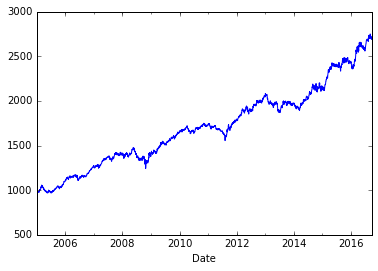

In [33]:
backtest(equalWeights['monthly'],returns).sum(axis=1).plot()

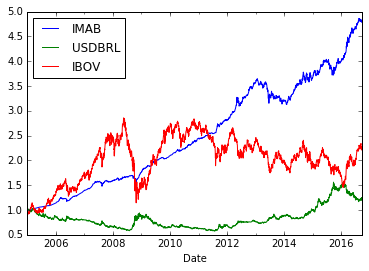

In [34]:
(returns+1).cumprod().plot()

In [35]:
help(port.tangency_portfolio)

Help on function tangency_portfolio in module portfolioopt.portfolioopt:

tangency_portfolio(cov_mat, exp_rets, allow_short=False)
    Computes a tangency portfolio, i.e. a maximum Sharpe ratio portfolio.
    
    Note: As the Sharpe ratio is not invariant with respect
    to leverage, it is not possible to construct non-trivial
    market neutral tangency portfolios. This is because for
    a positive initial Sharpe ratio the sharpe grows unbound
    with increasing leverage.
    
    Parameters
    ----------
    cov_mat: pandas.DataFrame
        Covariance matrix of asset returns.
    exp_rets: pandas.Series
        Expected asset returns (often historical returns).
    allow_short: bool, optional
        If 'False' construct a long-only portfolio.
        If 'True' allow shorting, i.e. negative weights.
    
    Returns
    -------
    weights: pandas.Series
        Optimal asset weights.



## Black Litterman

In [36]:
P.shape

NameError: name 'P' is not defined

In [ ]:
delta = 2.5
tau = 0.05

weq = np.array(marketCap.iloc[-1])
sigma = np.array(returns.cov())
P = np.array([0.1,0,0])
Q = np.array([0.05])
Omega = np.array([
        [0.1,0,0],
        [0,0.05,0],
        [0,0,0.02],
        ])
Omega = np.array([
        0.01
        ])
# Omega = sigma

x = bl.blacklitterman(delta, weq, sigma, tau, P, Q, Omega)

In [ ]:
help(bl.blacklitterman)

In [ ]:
(returns+1).cumprod().plot()

In [ ]:
returns.mean()

In [ ]:
returns.cov()